<a href="https://colab.research.google.com/github/orus-kade/pytorch_fatigue_classification/blob/master/demo_network_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt
import sys
sys.path.append('/content/drive/My Drive/fatigue')
import transforms as T
from torchvision import transforms, models
import matplotlib.pyplot as plt
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F


In [25]:
dir_path = '/content/drive/My Drive/fatigue/faces/no_dataset_faces'
# dir_path = '/content/drive/My Drive/fatigue/faces/val_data_second_minute/1_fatigue/01'
target = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#For CNN

In [126]:
def load_model_CNN(model_name, model_path, device):
  if model_name == 'r3d_18':
    model = models.video.r3d_18(pretrained=False)
  elif model_name == 'r2plus1d_18':
    model = models.video.r2plus1d_18(pretrained=False)
  elif model_name == 'mc3_18':
    model = models.video.mc3_18(pretrained=False)
  else:
    return None  
  model.fc = torch.nn.Linear(model.fc.in_features, 2)  
  model = torch.load(model_path)
  model.eval()
  model = model.to(device)
  return model

def load_data_for_CNN_from_dir(dir_path):
  paths = os.listdir(dir_path)
  paths.sort()
  my_face = paths[:15]
  transforms1 = transforms.Compose([transforms.Resize((112,112)), transforms.ToTensor()])
  transforms2 = transforms.Compose([                                      
            T.ToFloatTensorInZeroOne(),
            T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
        ])
  clip = torch.Tensor()
  for img_file in [dir_path+os.path.sep+x for x in my_face]:
    img = Image.open(img_file)
    img_tensor = transforms1(img)
    clip = torch.cat((clip, img_tensor.unsqueeze(0)), dim = 0)
  clip = clip.permute(0,2,3,1)
  clip = transforms2(clip)  
  return clip

def load_data_for_CNN_form_img_arr(img_arr):
  transforms1 = transforms.Compose([transforms.Resize((112,112)), transforms.ToTensor()])
  transforms2 = transforms.Compose([                                      
            T.ToFloatTensorInZeroOne(),
            T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
        ])
  clip = torch.Tensor()
  for img in img_arr:
    img_tensor = transforms1(img)
    clip = torch.cat((clip, img_tensor.unsqueeze(0)), dim = 0)
  clip = clip.permute(0,2,3,1)
  clip = transforms2(clip)  
  return clip

def show_clip_frames_CNN(clip):
  mean = np.array([0.43216, 0.394666, 0.37645])
  std = np.array([0.22803, 0.22145, 0.216989])
  fgs, axis = plt.subplots(3,5, figsize = (20,10))
  for ax, i in zip (axis.ravel(), range(clip.shape[1])):
    frame = clip.permute(1, 0, 2, 3)[i]
    frame = (frame.permute(1,2,0).numpy() * std + mean) * 255
    ax.imshow(frame)  

def predict_CNN(model, clip, device):
  with torch.set_grad_enabled(False):
    pred = model(torch.unsqueeze(clip, dim=0).to(device))
    pred = pred.argmax(dim=1).to('cpu').numpy()
    return pred

# For CNN+RNN

In [21]:
class Identity(torch.nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return x

class MyLSTM(nn.Module):
    def __init__(self, num_targets, emb_size, lstm_num_units, dropout = 0.1):
        super(self.__class__, self).__init__()
        self.lstm = nn.LSTM(emb_size, lstm_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(lstm_num_units, num_targets)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        assert isinstance(x, Variable) and isinstance(x.data, torch.FloatTensor)
        x = self.dropout(x)
        h_seq, _ = self.lstm(x)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

    def predict_class(self, sqns):
        with torch.no_grad():
            tags_pred = model(sqns).numpy()
            tags_pred = np.argmax(tags_pred[0][-1], axis=0)  
        return tags_pred   


def load_models_CNN_and_RNN(resnet_name, model_name, model_path, device):
  if resnet_name == 'resnet_18':
    resnet = models.resnet18(pretrained=True)
    len_sq = 512
  elif resnet_name == 'resnet_34':
    resnet = models.resnet34(pretrained=True)
    len_sq = 512
  elif resnet_name == 'resnet_50':
    resnet = models.resnet50(pretrained=True)
    len_sq = 2048
  else:
    return None

  resnet.fc = Identity()
  resnet.eval()
  resnet.to(device)

  if model_name == 'lstm_128':
    rnn_num_units = 128
  elif model_name == 'lstm_256':
    rnn_num_units = 256
  else:
    return None

  model = MyLSTM(2, len_sq, rnn_num_units)
  model.load_state_dict(torch.load(model_path))
  model.eval()
  # model.to(device)

  return resnet, model

def load_data_for_resnet_from_dir(dir_path):
  paths = os.listdir(dir_path)
  paths.sort()
  my_face = paths[:15]

  arr_transforms = transforms.Compose([
    transforms.Resize((224,224)),                                    
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  clip = torch.Tensor()
  for img_file in [dir_path+os.path.sep+x for x in my_face]:
    img = Image.open(img_file)
    img_tensor = arr_transforms(img)
    clip = torch.cat((clip, img_tensor.unsqueeze(0)), dim = 0)
  return clip

def load_data_for_resnet_from_img_arr(img_arr):
  arr_transforms = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  clip = torch.Tensor()
  for img in img_arr:
    img_tensor = arr_transforms(img)
    clip = torch.cat((clip, img_tensor.unsqueeze(0)), dim = 0)
  return clip

def show_clip_frames_CNN(clip):
  mean = np.array([0.43216, 0.394666, 0.37645])
  std = np.array([0.22803, 0.22145, 0.216989])
  fgs, axis = plt.subplots(3,5, figsize = (20,10))
  for ax, i in zip (axis.ravel(), range(clip.shape[0])):
    frame = clip[i]
    frame = (frame.permute(1,2,0).numpy() * std + mean)
    ax.imshow(frame)   

def feature_extraction(resnet, clip, device):
  with torch.no_grad():
    features = resnet(clip.to(device))
    return features.to('cpu').numpy()

def data_for_lstm(features):
  arr = []
  for f in features:
    arr.append(f)
  data = torch.tensor(arr, dtype=torch.float)  
  data = data.unsqueeze(0)
  return data  

def predict_cnn_and_rnn(model, resnet, clip, device):
  features =  feature_extraction(resnet, clip, device)
  data = data_for_lstm(features)
  pred = model.predict_class(data)
  return pred


#Test CNN

In [22]:
# %%time

# ResNet(2+1)D все слои

model_name = 'r2plus1d_18'
model_path = '/content/drive/My Drive/fatigue/results/4rd mc3_18 pretrained/model_r2plus1d_18_all.pth'

model = load_model_CNN(model_name, model_path, device)   
# print(model)
clip_data = load_data_for_CNN_from_dir(dir_path)
show_clip_frames_CNN(clip_data)
print('Target {}'.format(target))
pred = predict_CNN(model, clip_data, device)
print('Predicion {}'.format(pred[0]))


NameError: ignored

## Some time tests

In [42]:
%%time
model_name = 'r2plus1d_18'
model_path = '/content/drive/My Drive/fatigue/results/4rd mc3_18 pretrained/model_r2plus1d_18_all.pth'
model = load_model_CNN(model_name, model_path, device)

CPU times: user 564 ms, sys: 80.6 ms, total: 644 ms
Wall time: 727 ms


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv3d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [54]:
%%time
clip_data = load_data_for_CNN(dir_path)

Время :
0.05176234245300293


In [67]:
img_arr = []
paths = os.listdir(dir_path)
paths.sort()
my_face = paths[:15]
for img_file in [dir_path+os.path.sep+x for x in my_face]:
  img = Image.open(img_file)
  img_arr.append(img)

In [71]:
%%time
clip = load_data_for_CNN_form_img_arr(img_arr)

CPU times: user 15.4 ms, sys: 907 µs, total: 16.3 ms
Wall time: 17.2 ms


In [59]:
%%time
print('Target {}'.format(target))
pred = predict_CNN(model, clip_data, device)
print('predict {}'.format(pred))

Target 0
predict [0]
Время :
0.09074735641479492
CPU times: user 54.7 ms, sys: 33 ms, total: 87.7 ms
Wall time: 90.8 ms


#Test CNN+RNN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Target 1
Prediction 1


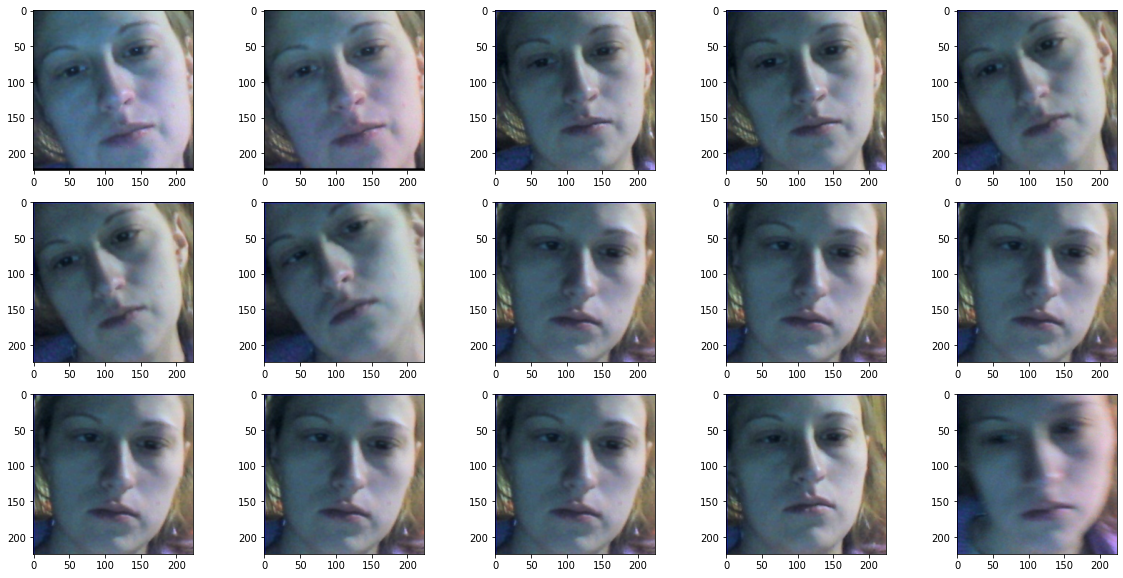

In [26]:
resnet_name = 'resnet_18'
model_name = 'lstm_128'
model_path = '/content/drive/My Drive/fatigue/results/3rd resnet50 pretrained feature extraction/lstm_128_hidden/model_best_hidden_128_reatures_512_resnet18.pth'

resnet, model = load_models_CNN_and_RNN(resnet_name, model_name, model_path, device)
# print(resnet)
# print(model)
clip_data = load_data_for_resnet_from_dir(dir_path)
show_clip_frames_CNN(clip_data)
print('Target {}'.format(target))
pred = predict_cnn_and_rnn(model, resnet, clip_data, device)
print('Prediction {}'.format(pred))


##Some time tests

In [105]:
img_arr = []
paths = os.listdir(dir_path)
paths.sort()
my_face = paths[:15]
for img_file in [dir_path+os.path.sep+x for x in my_face]:
  img = Image.open(img_file)
  img_arr.append(img)

In [109]:
%%time
clip_data = load_data_for_resnet_from_img_arr(img_arr)

CPU times: user 26.6 ms, sys: 2.94 ms, total: 29.5 ms
Wall time: 29.7 ms


In [108]:
%%time
clip_data = load_data_for_resnet_from_dir(dir_path)

CPU times: user 47.7 ms, sys: 3.07 ms, total: 50.8 ms
Wall time: 66.8 ms
